<a href="https://colab.research.google.com/github/avinashnanda/CategoricalEncodingBenchmark/blob/master/natural%20language%20processing/use_text_classification_cyclic_learning_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np
from keras.layers import Input, Lambda, Dense, Reshape
from keras.models import Model
import keras.backend as K
import matplotlib.pyplot as plt
from learningratefinder import LearningRateFinder
from clr_callback import CyclicLR

In [2]:
## download the cleaned data from earlier word embedding pretrained notebook.

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/train_clean.csv" /content
!cp "/content/drive/My Drive/test_clean.csv" /content

In [0]:
train = pd.read_csv("train_clean.csv")
test_df = pd.read_csv("test_clean.csv")

In [0]:
from sklearn.model_selection import train_test_split
train_df,val_df = train_test_split(train, test_size=0.20,random_state=2)

In [0]:
train_X = np.asarray(train_df["clean_text"].fillna("_na_").values)
val_X = np.asarray(val_df["clean_text"].fillna("_na_").values)
test_X = np.asarray(test_df["clean_text"].fillna("_na_").values)


In [0]:
train_y = np.asarray(train_df[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']].values)
val_y = np.asarray(val_df[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']].values)

In [0]:
url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(url)

In [0]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

In [0]:
# saving only weights as keras is failing to load custom attention layer
from keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True,
    mode='auto'
)

early_stop = EarlyStopping(
        monitor     = 'val_loss', 
        patience    = 3, 
        mode        = 'auto', 
        verbose     = 1,
    restore_best_weights = True
    
    )

In [9]:
inp = Input(shape=(1,), dtype=tf.string)
x = Lambda(UniversalEmbedding, output_shape=(512, ))(inp)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 148,166
Trainable params: 148,166
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
print("[INFO] finding learning rate...")
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    lrf = LearningRateFinder(model)
    lrf.find((train_X[1:40000], train_y[1:40000]),1e-10, 1e+1,epochs=30,
            stepsPerEpoch=np.ceil((len(train_X[1:40000]) / float(2048))),
            batchSize=2048)

[INFO] finding learning rate...



Epoch 1/30



39999/39999 [==============================] - 95s 2ms/step - loss: 0.6954 - acc: 0.4494
Epoch 2/30
39999/39999 [==============================] - 93s 2ms/step - loss: 0.6954 - acc: 0.4494
Epoch 3/30
39999/39999 [==============================] - 93s 2ms/step - loss: 0.6954 - acc: 0.4494
Epoch 4/30
39999/39999 [==============================] - 93s 2ms/step - loss: 0.6954 - acc: 0.4494
Epoch 5/30
39999/39999 [==============================] - 93s 2ms/step - loss: 0.6954 - acc: 0.4494
Epoch 6/30
39999/39999 [==============================] - 93s 2ms/step - loss: 0.6954 - acc: 0.4495
Epoch 7/30
39999/39999 [==============================] - 93s 2ms/step - loss: 0.6953 - acc: 0.4496
Epoch 8/30
39999/39999 [==============================] - 93s 2ms/step - loss: 0.6953 - acc: 0.4499
Epoch 9/30
39999/39999 [==============================] - 93s 2ms/step - loss: 0.6953 - acc: 0.4504
Epoch 10/30
39999/39999 [==============================] - 93s 2ms/step - loss: 0.6952 - acc: 0.4518
Epoch 11/3

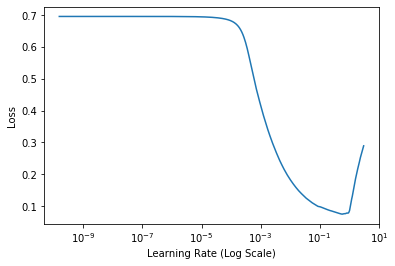

In [11]:
lrf.plot_loss()

In [0]:
MIN_LR = 1e-5
MAX_LR = 1e-2
BATCH_SIZE = 2048
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS = 48

In [15]:
# otherwise, we have already defined a learning rate space to train
# over, so compute the step size and initialize the cyclic learning
# rate method
stepSize = STEP_SIZE * (train_X.shape[0] // BATCH_SIZE)
clr = CyclicLR(
	mode=CLR_METHOD,
	base_lr=MIN_LR,
	max_lr=MAX_LR,
	step_size=stepSize)
 
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history =  model.fit(train_X,train_y, batch_size=2048, epochs=30,validation_data=(val_X, val_y),callbacks = [checkpoint,early_stop,clr])

Train on 127656 samples, validate on 31915 samples
Epoch 1/30
127656/127656 [==============================] - 373s 3ms/step - loss: 0.4280 - acc: 0.8819 - val_loss: 0.1135 - val_acc: 0.9633

Epoch 00001: val_loss improved from inf to 0.11351, saving model to model.h5
Epoch 2/30
127656/127656 [==============================] - 371s 3ms/step - loss: 0.0769 - acc: 0.9723 - val_loss: 0.0602 - val_acc: 0.9783

Epoch 00002: val_loss improved from 0.11351 to 0.06016, saving model to model.h5
Epoch 3/30
127656/127656 [==============================] - 371s 3ms/step - loss: 0.0571 - acc: 0.9793 - val_loss: 0.0553 - val_acc: 0.9795

Epoch 00003: val_loss improved from 0.06016 to 0.05531, saving model to model.h5
Epoch 4/30
127656/127656 [==============================] - 372s 3ms/step - loss: 0.0535 - acc: 0.9802 - val_loss: 0.0536 - val_acc: 0.9797

Epoch 00004: val_loss improved from 0.05531 to 0.05365, saving model to model.h5
Epoch 5/30
127656/127656 [==============================] - 371s 

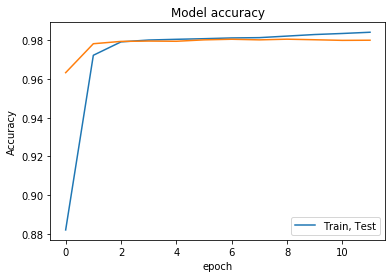

In [18]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train, Test'], loc=0)
    
def plot_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train, Test'], loc=0)

plot_acc(history)



In [0]:
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

In [20]:

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights("/content/model.h5")  

    y_test2 = model.predict([test_X], batch_size=3072, verbose=1)
    sample_submission = pd.read_csv('sample_submission.csv')
    sample_submission[list_classes] = y_test2
    sample_submission.to_csv('submission333.csv', index=False)

153164/153164 [==============================] - 353s 2ms/step


In [12]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history =  model.fit(train_X,train_y, batch_size=2048, epochs=30,validation_data=(val_X, val_y),callbacks = [checkpoint,early_stop])

Train on 127656 samples, validate on 31915 samples
Epoch 1/30



127656/127656 [==============================] - 373s 3ms/step - loss: 0.2422 - acc: 0.9505 - val_loss: 0.0883 - val_acc: 0.9673

Epoch 00001: val_loss improved from inf to 0.08827, saving model to model.h5
Epoch 2/30
127656/127656 [==============================] - 371s 3ms/step - loss: 0.0714 - acc: 0.9746 - val_loss: 0.0625 - val_acc: 0.9778

Epoch 00002: val_loss improved from 0.08827 to 0.06254, saving model to model.h5
Epoch 3/30
127656/127656 [==============================] - 371s 3ms/step - loss: 0.0594 - acc: 0.9786 - val_loss: 0.0579 - val_acc: 0.9788

Epoch 00003: val_loss improved from 0.06254 to 0.05793, saving model to model.h5
Epoch 4/30
127656/127656 [==============================] - 371s 3ms/step - loss: 0.0565 - acc: 0.9792 - val_loss: 0.0559 - val_acc: 0.9792

Epoch 00004: val_loss improved from 0.05793 to 0.05588, saving model to model.h5
Epoch 5/30
127656/127656 [==============================] - 373s 3ms/step - loss: 0.0548 - acc: 0.9796 - val_loss: 0.0546 - val

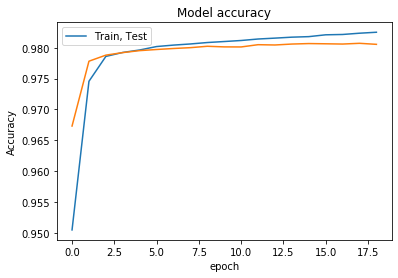

In [13]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train, Test'], loc=0)
    
def plot_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train, Test'], loc=0)

plot_acc(history)



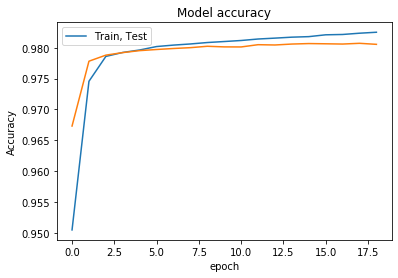

In [14]:
plot_acc(history)

In [0]:
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

In [17]:

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights("/content/model.h5")  

    y_test2 = model.predict([test_X], batch_size=3072, verbose=1)
    sample_submission = pd.read_csv('sample_submission.csv')
    sample_submission[list_classes] = y_test2
    sample_submission.to_csv('submission3.csv', index=False)

153164/153164 [==============================] - 353s 2ms/step
